
# BERT FINE TUNING MODEL

In [7]:
import json
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import time

## ***Step 1:*** Download SQuAD 2.0 dataset and Tranformers library

In [8]:
%%capture
!mkdir squad
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v2.0.json -O squad/train-v2.0.json
!wget https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v2.0.json -O squad/dev-v2.0.json

In [9]:
%%capture
!pip install transformers

## ***Step 2:*** Retrieve and Store the data

Here I take and store the texts, queries and answers from the train and validation .json files. If we look carefully we will see that in these files there are a number of queries and answers for each passage. I save these informations into lists.

In [10]:
# Give the path for train data
path = Path('/kaggle/working/squad/train-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer)

train_texts, train_queries, train_answers = texts, queries, answers

In [11]:
# Give the path for validation data
path = Path('/kaggle/working/squad/dev-v2.0.json')

# Open .json file
with open(path, 'rb') as f:
    squad_dict = json.load(f)

texts = []
queries = []
answers = []

# Search for each passage, its question and its answer
for group in squad_dict['data']:
    for passage in group['paragraphs']:
        context = passage['context']
        for qa in passage['qas']:
            question = qa['question']
            for answer in qa['answers']:
                # Store every passage, query and its answer to the lists
                texts.append(context)
                queries.append(question)
                answers.append(answer)

val_texts, val_queries, val_answers = texts, queries, answers

## ***Step 3:*** Check the data

As you can see we have 86821 passages, queries and answers from the training data. The answer is stored in a dictionary with the specific answer in the "text" cell and the accurate character index that the answer is started in cell "answer start". As we observe, is missing the information about the exact index of the character that the answer is ending.

In [12]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

86821
86821
86821


In [13]:
print("Passage: ",train_texts[0])  
print("Query: ",train_queries[0])
print("Answer: ",train_answers[0])

Passage:  Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles "Crazy in Love" and "Baby Boy".
Query:  When did Beyonce start becoming popular?
Answer:  {'text': 'in the late 1990s', 'answer_start': 269}


As you can see we have 20302 passages, queries and answers from the validation data

In [14]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

20302
20302
20302


In [15]:
print("Passage: ",val_texts[0])  
print("Query: ",val_queries[0])
print("Answer: ",val_answers[0])

Passage:  The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
Query:  In what country is Normandy located?
Answer:  {'text': 'France', 'answer_start': 159}


This was helped me to split my dataset in order to run my notebook in my first attemps.

In [16]:
train_texts = train_texts[:20000]
train_queries = train_queries[:20000]
train_answers = train_answers[:20000]

val_texts = val_texts[:20000]
val_queries = val_queries[:20000]
val_answers = val_answers[:20000]

In [17]:
print(len(train_texts))
print(len(train_queries))
print(len(train_answers))

20000
20000
20000


In [18]:
print(len(val_texts))
print(len(val_queries))
print(len(val_answers))

20000
20000
20000


## ***Step 4:*** Find the end position character

Find end position character in train data

In [19]:
for answer, text in zip(train_answers, train_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2    

Find end position character in validation data

In [20]:
for answer, text in zip(val_answers, val_texts):
    real_answer = answer['text']
    start_idx = answer['answer_start']
    # Get the real end index
    end_idx = start_idx + len(real_answer)

    # Deal with the problem of 1 or 2 more characters 
    if text[start_idx:end_idx] == real_answer:
        answer['answer_end'] = end_idx
    # When the real answer is more by one character
    elif text[start_idx-1:end_idx-1] == real_answer:
        answer['answer_start'] = start_idx - 1
        answer['answer_end'] = end_idx - 1  
    # When the real answer is more by two characters  
    elif text[start_idx-2:end_idx-2] == real_answer:
        answer['answer_start'] = start_idx - 2
        answer['answer_end'] = end_idx - 2   

## ***Step 5:*** Tokenize passages and queries

In this task is asked to select the BERT-base pretrained model “bert-base-uncased” for the tokenization

In [21]:
from transformers import AutoTokenizer,AdamW,BertForQuestionAnswering
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

train_encodings = tokenizer(train_texts, train_queries, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, val_queries, truncation=True, padding=True)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## ***Step 6:*** Convert the start-end positions to tokens start-end positions 

In [22]:
def add_token_positions(encodings, answers):
  start_positions = []
  end_positions = []

  count = 0

  for i in range(len(answers)):
    start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
    end_positions.append(encodings.char_to_token(i, answers[i]['answer_end']))

    # if start position is None, the answer passage has been truncated
    if start_positions[-1] is None:
      start_positions[-1] = tokenizer.model_max_length
      
    # if end position is None, the 'char_to_token' function points to the space after the correct token, so add - 1
    if end_positions[-1] is None:
      end_positions[-1] = encodings.char_to_token(i, answers[i]['answer_end'] - 1)
      # if end position is still None the answer passage has been truncated
      if end_positions[-1] is None:
        count += 1
        end_positions[-1] = tokenizer.model_max_length

  print(count)

  # Update the data in dictionary
  encodings.update({'start_positions': start_positions, 'end_positions': end_positions})

add_token_positions(train_encodings, train_answers)
add_token_positions(val_encodings, val_answers)

2
16


I observed that after tokenize the end position character, sometimes was still None. This happended only for 10 answers in train data (of total 86821) and 16 answers in validation data (of total 20302). So I decided to move the answer 1 position left. If it was still None then I give them the model_max_length as before. I have to refer that I was trying to see if the answers in this case was 1 postition after (so I added +1 to the end position) or 2 positions left or right (+/- 2 positions), but the answers that there are still None was more (ie 526, while with this code there only 10). So I kept this strategy in the end, in order to have as less as possible "burned" answers.

## ***Step 7:*** Create a Dataset class 

Create a Squatdataset class (inherits from torch.utils.data.Dataset), that helped me to train and validate my previous data more easily and convert encodings to datasets.

In [23]:
class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

In [24]:
train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)

## ***Step 8:*** Use of DataLoader

I put my previous data to DataLoader, so as to split them in "pieces" of 8 batch size. I will explain the selection of this value of batch size later.

In [25]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)

## ***Step 9:*** Use GPU

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available()
                      else 'cpu')

## ***Step 10:*** Build the Bert model

I select BertForQuestionAnswering from transformers library, as it was the most relative with this task.


In [27]:
model = BertForQuestionAnswering.from_pretrained('bert-base-uncased').to(device)

optim = AdamW(model.parameters(), lr=5e-5)
# optim = AdamW(model.parameters(), lr=3e-5)
# optim = AdamW(model.parameters(), lr=2e-5)

epochs = 2
# epochs = 3
# epochs = 4

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


## ***Step 11:*** Train and Evaluate Model

Training of model was done exactly as in the previous projects.

In [28]:
whole_train_eval_time = time.time()

train_losses = []
val_losses = []

print_every = 1000

for epoch in range(epochs):
  epoch_time = time.time()

  # Set model in train mode
  model.train()
    
  loss_of_epoch = 0

  print("############Train############")

  for batch_idx,batch in enumerate(train_loader): 
    
    optim.zero_grad()

    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    # do a backwards pass 
    loss.backward()
    # update the weights
    optim.step()
    # Find the total loss
    loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
      print("Batch {:} / {:}".format(batch_idx+1,len(train_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(train_loader)
  train_losses.append(loss_of_epoch)

  ##########Evaluation##################

  # Set model in evaluation mode
  model.eval()

  print("############Evaluate############")

  loss_of_epoch = 0

  for batch_idx,batch in enumerate(val_loader):
    
    with torch.no_grad():

      input_ids = batch['input_ids'].to(device)
      attention_mask = batch['attention_mask'].to(device)
      start_positions = batch['start_positions'].to(device)
      end_positions = batch['end_positions'].to(device)
      
      outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
      loss = outputs[0]
      # Find the total loss
      loss_of_epoch += loss.item()

    if (batch_idx+1) % print_every == 0:
       print("Batch {:} / {:}".format(batch_idx+1,len(val_loader)),"\nLoss:", round(loss.item(),1),"\n")

  loss_of_epoch /= len(val_loader)
  val_losses.append(loss_of_epoch)

  # Print each epoch's time and train/val loss 
  print("\n-------Epoch ", epoch+1,
        "-------"
        "\nTraining Loss:", train_losses[-1],
        "\nValidation Loss:", val_losses[-1],
        "\nTime: ",(time.time() - epoch_time),
        "\n-----------------------",
        "\n\n")

print("Total training and evaluation time: ", (time.time() - whole_train_eval_time))

############Train############
Batch 1000 / 2500 
Loss: 1.6 

Batch 2000 / 2500 
Loss: 0.8 

############Evaluate############
Batch 1000 / 2500 
Loss: 1.2 

Batch 2000 / 2500 
Loss: 1.3 


-------Epoch  1 -------
Training Loss: 1.561319857096672 
Validation Loss: 1.4005999409377574 
Time:  1394.8788719177246 
----------------------- 


############Train############
Batch 1000 / 2500 
Loss: 0.4 

Batch 2000 / 2500 
Loss: 1.2 

############Evaluate############
Batch 1000 / 2500 
Loss: 1.5 

Batch 2000 / 2500 
Loss: 1.5 


-------Epoch  2 -------
Training Loss: 0.7685107603579759 
Validation Loss: 1.4023057844758033 
Time:  1392.6638543605804 
----------------------- 


Total training and evaluation time:  2787.5435898303986


In [32]:
from huggingface_hub import notebook_login

notebook_login()

In [33]:
# push model to hub
model.push_to_hub("fahmiaziz/bert-squad-v2")
tokenizer.push_to_hub("fahmiaziz/bert-squad-v2")

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/fahmiaziz/bert-squad-v2/commit/40756dbc251594771e49fdb11fed910cf5b98b0e', commit_message='Upload tokenizer', commit_description='', oid='40756dbc251594771e49fdb11fed910cf5b98b0e', pr_url=None, pr_revision=None, pr_num=None)

## ***Step 12:*** Plot train and validation losses

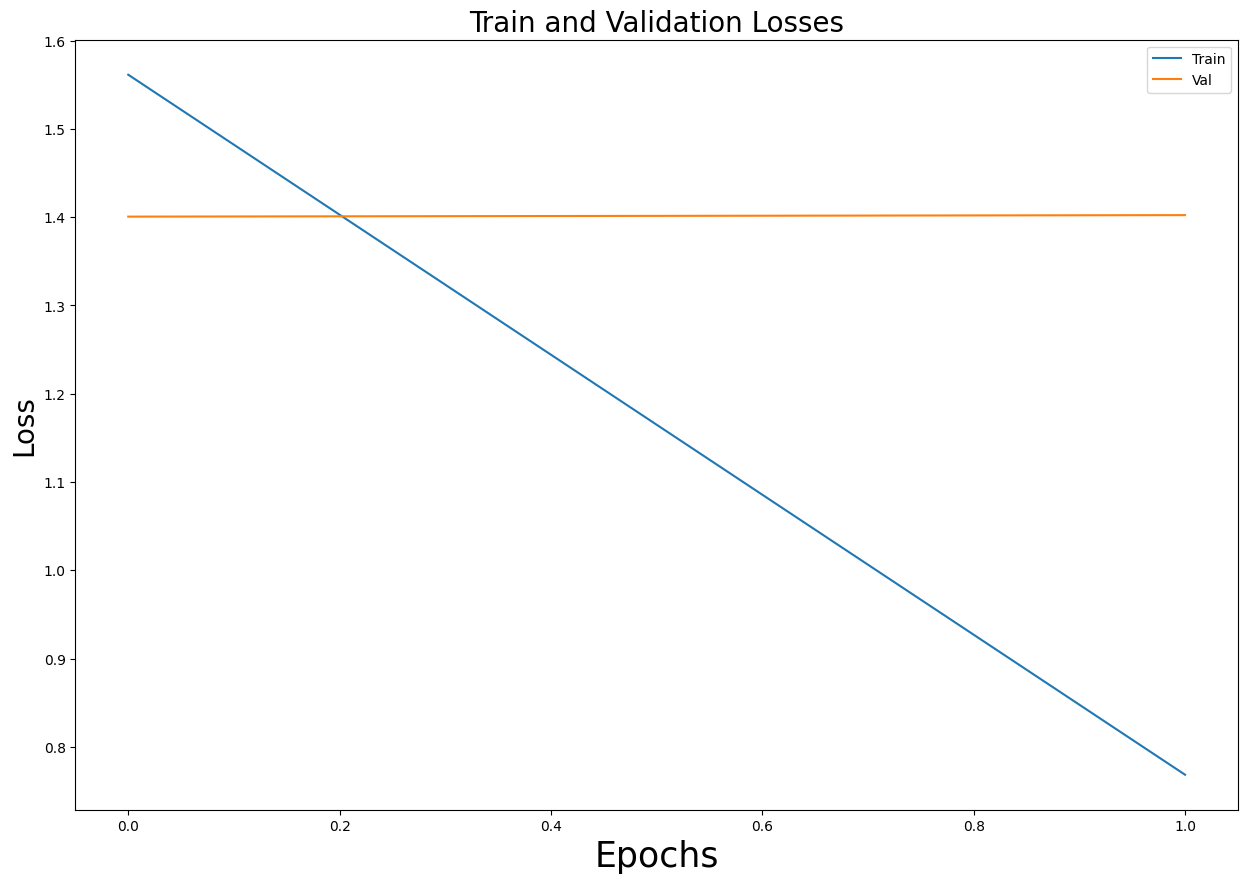

In [34]:
import matplotlib.pyplot as plt 

fig,ax = plt.subplots(1,1,figsize=(15,10))

ax.set_title("Train and Validation Losses",size=20)
ax.set_ylabel('Loss', fontsize = 20) 
ax.set_xlabel('Epochs', fontsize = 25) 
_=ax.plot(train_losses)
_=ax.plot(val_losses)
_=ax.legend(('Train','Val'),loc='upper right')

In [ ]:

# def evaluate(loader):
#   model.eval()

#   preds = []
#   labels = []

#   with torch.no_grad():
#     for batch in loader:
#       input_ids = batch['input_ids'].to(device)
#       attention_mask = batch['attention_mask'].to(device)

#       output = model(input_ids, attention_mask=attention_mask)
#       start_scores = output.start_logits
#       end_scores = output.end_logits

#       for i in range(len(input_ids)):
#         start_index = torch.argmax(start_scores[i])
#         end_index = torch.argmax(end_scores[i])
#         answer = tokenizer.convert_tokens_to_string(tokenizer.convert_ids_to_tokens(input_ids[i][start_index:end_index+1]))
#         preds.append(answer)
#         labels.append(batch['answer'][i])

#   return f1_score(labels, preds)

  

## ***Step 13:*** Summaries

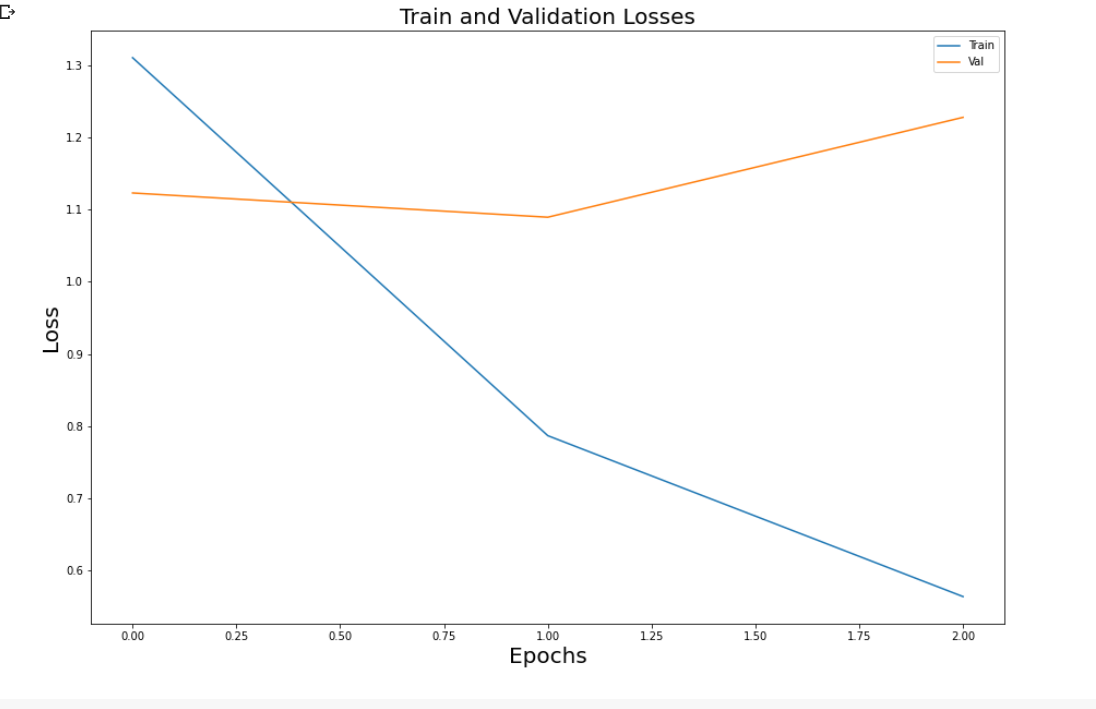

ref - https://github.com/alexaapo/BERT-based-pretrained-model-using-SQuAD-2.0-dataset